In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, Tensor

from model import ScoreNetwork0

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce

# Flatten the images into a vector
# flatten = lambda x: ToTensor()(x).view(28**2)

preprocess = lambda x: 2*(ToTensor()(x))-1


# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=preprocess, download=True)
dset_test  = MNIST("./", train=False, transform=preprocess)

# The digit classes to use
classes = list(range(10))

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
eval_batch_size = 100
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets))
test_loader  = DataLoader(dset_test, batch_size=eval_batch_size,
                          sampler=stratified_sampler(dset_test.targets))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.20MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 243kB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.18MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



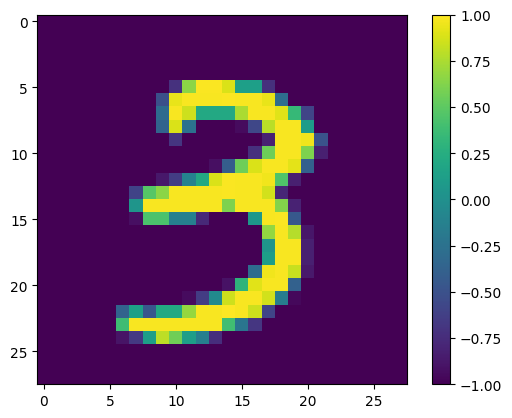

In [4]:
im = next(iter(train_loader))[0][0].numpy().squeeze()
plt.imshow(im)
plt.colorbar()

## Parameters


In [5]:
data_dim = (1, 28, 28)
T = 1000
beta = torch.linspace(1e-4, 0.02, T, device=device)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

## Training

In [6]:

def calc_loss(model: ScoreNetwork0, loss_fn: nn.MSELoss, x: Tensor) -> Tensor:
    t = torch.randint(0, T, size=(x.shape[0],1), device=device)
    t = t[..., None, None].expand_as(x)
    ab_t = alpha_bar[t]
    eps = torch.randn_like(x, device=device)
    s = torch.sqrt(ab_t)*x + torch.sqrt(1-ab_t)*eps
    out = model(s, t)
    return loss_fn(eps, out)



## Sampling

In [7]:
def sampling(model: ScoreNetwork0):
    x = torch.randn(size=data_dim, device=device)
    for t in range(T-1, -1, -1):
        z = torch.randn(size=data_dim) if t > 0 else torch.zeros(size=data_dim)
        z = z.to(device)
        t_tensor = t*torch.ones_like(x, device=device)
        out = model(x, t_tensor)
        sd = torch.sqrt(beta[t])
        x = 1/torch.sqrt(alpha[t])*(x - beta[t]/torch.sqrt(1-alpha_bar[t])*out) + sd*z
    return x

# Implementation

In [8]:
def train_loop(dataloader: DataLoader, model: ScoreNetwork0, loss_fn: nn.MSELoss, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        loss = calc_loss(model, loss_fn, X.to(device))

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # test_loss, correct = 0, 0
    test_loss = 0
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            L = calc_loss(model, loss_fn, X.to(device))
            test_loss += L.item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    # correct /= size
    print(f"Test Loss: {test_loss:>8f} \n")

In [ ]:

print(device)

model = ScoreNetwork0(channels=1).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")

cuda
Epoch 1
-------------------------------
loss: 239.570343  [   64/60000]
loss: 0.966893  [ 6464/60000]
loss: 0.882220  [12864/60000]
loss: 0.828990  [19264/60000]
loss: 0.767576  [25664/60000]
loss: 0.715924  [32064/60000]
loss: 0.563644  [38464/60000]
loss: 0.420031  [44864/60000]
loss: 0.405564  [51264/60000]
loss: 0.316083  [57664/60000]
Test Loss: 0.330109 

Epoch 2
-------------------------------
loss: 0.333895  [   64/60000]
loss: 0.306499  [ 6464/60000]
loss: 0.263654  [12864/60000]
loss: 0.259736  [19264/60000]
loss: 0.259991  [25664/60000]
loss: 0.192605  [32064/60000]
loss: 0.236744  [38464/60000]
loss: 0.181159  [44864/60000]
loss: 0.229515  [51264/60000]
loss: 0.197612  [57664/60000]
Test Loss: 0.177000 

Epoch 3
-------------------------------
loss: 0.144969  [   64/60000]
loss: 0.194491  [ 6464/60000]
loss: 0.154217  [12864/60000]
loss: 0.207333  [19264/60000]
loss: 0.150688  [25664/60000]
loss: 0.160324  [32064/60000]
loss: 0.143123  [38464/60000]
loss: 0.223771  [44

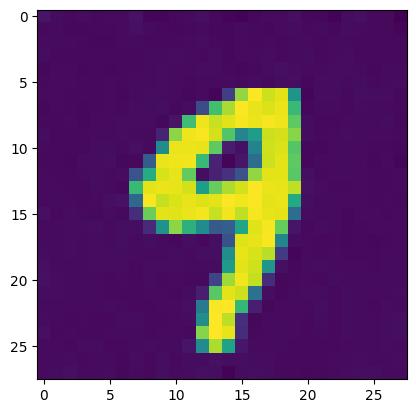

In [30]:
sample = sampling(model)
sample = sample.detach().cpu().numpy()
plt.imshow(np.squeeze(sample))

In [32]:
torch.save(model.state_dict(), 'mnist_model.pt')